In [42]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from io import BytesIO,StringIO
import pygraphviz
import six


In [43]:
#i
#ii
#Wczytanie danych oraz ich nazwanie
data = pd.read_table('wine.data', sep=",", header=None, index_col = None 
                   ,names = ["Class", "Alcohol", "Malic acid", "Ash"
                    ,"Alcalinity of ash","Magnesium","Total phenols"
                    ,"Flavanoids","Nonflavanoid phenols","Proanthocyanins"
                    ,"Color Intensity","Hue","OD280/OD315 of diluted wines","Proline"]);

n_max = len(data.columns) - 1 

#Wybór ilości kolumn
X = data.iloc[:,1:14]
#Wektor Klas 
y = data.iloc[:,0]

In [44]:
#iii 
tree = DecisionTreeClassifier()
tree.fit(X,y)
predictions = tree.predict(X)

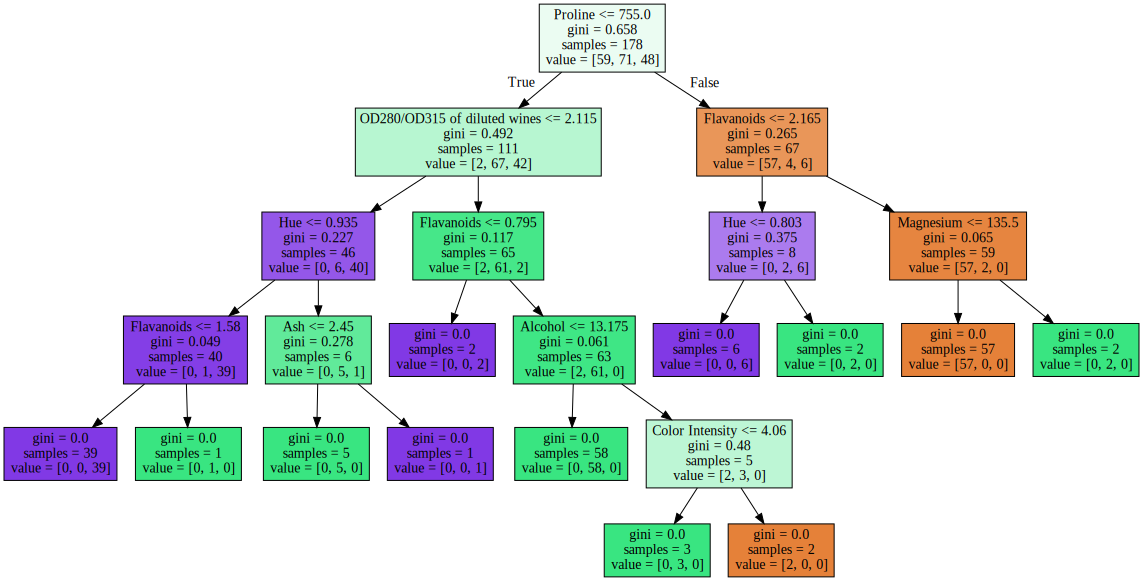

In [49]:
#iv
export_graphviz(tree, out_file="mytree.svg",feature_names = X.columns[0:], filled = True, rotate = False)
with open("mytree.svg") as f:
       dot_graph = f.read()
tree = graphviz.Source(dot_graph)
tree


In [46]:
#v 
#Macierz pomyłek i skuteczność klasyfikatora dla powtórnego podstawienia
print(confusion_matrix(y,predictions))
print("Accuracy: ",accuracy_score(y, predictions))

[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]
Accuracy:  1.0


In [6]:
#Przewidywane wartości dla 10-krotnej kroswalidacji 
cross_val_predictions = cross_val_predict(tree, X, y, cv=10)
#Macierz pomyłek i skuteczność klasyfikatora dla 10-krotnej kroswalidacji
print(confusion_matrix(y,cross_val_predictions))
print("Accuracy: ",accuracy_score(y, cross_val_predictions))

[[55  4  0]
 [ 8 58  5]
 [ 0  6 42]]
Accuracy:  0.8707865168539326


In [7]:
#vi 
#Szukam wartości ccp_alphas w celu znalezienia optymalnego drzewa
opt_tree = DecisionTreeClassifier()
path = opt_tree.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

In [8]:
ccp_trees = []
for ccp_alpha in ccp_alphas:
    ccp_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    ccp_tree.fit(X, y)
    ccp_predictions = cross_val_predict(ccp_tree, X, y, cv=10)
    ccp_trees.append(accuracy_score(y, ccp_predictions))

In [9]:
print("Wartość maksymalna dla ccp_alpha nr:",max(ccp_trees).shape)

Wartość maksymalna dla ccp_alpha nr: ()


In [10]:
#Sprawdzam która wartość ccp_alha jest największa i pozwoli
#na konstrukcje optymalnego drzewa
ccp_trees.index(max(ccp_trees))

4

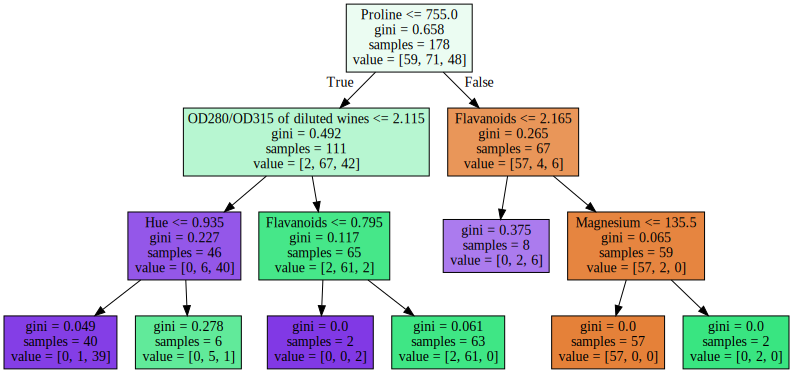

In [50]:
#Rysuje optymalne drzewo dla wyżej wyznaczonego ccp_alpha
ccp_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[4])
ccp_tree.fit(X, y)
ccp_opt_predictions = cross_val_predict(ccp_tree, X, y, cv=10)
    
export_graphviz(ccp_tree, out_file="opt_ccp_tree.svg",feature_names = X.columns[0:], filled = True, rotate = False)
with open("opt_ccp_tree.svg") as f:
    dot_graph = f.read()
treeopt = graphviz.Source(dot_graph)
treeopt

In [44]:
#Macierz pomyłek i skuteczność klasyfikatora dla 10-krotnej kroswalidacji dla optymalnego drzewa
print("Drzewo optymalne\n")
print(confusion_matrix(y,ccp_opt_predictions),"\n")
print("Accuracy: ",accuracy_score(y, ccp_opt_predictions),"\n")

#Macierz pomyłek i skuteczność klasyfikatora dla pełnego drzewa
print("Drzewo pełne\n")
print(confusion_matrix(y,cross_val_predictions),"\n")
print("Accuracy: ",accuracy_score(y, cross_val_predictions))

Drzewo optymalne

[[55  4  0]
 [ 4 60  7]
 [ 0  6 42]] 

Accuracy:  0.8820224719101124 

Drzewo pełne

[[55  4  0]
 [ 7 59  5]
 [ 4  2 42]] 

Accuracy:  0.8764044943820225


Skuteczność dla drzewa optymalnego (przyciętego) wzrosła w stosunku do drzewa pełnego

In [46]:
#vii
full_leaves = []
full_trees_scores = []
opt_trees = []
opt_trees_scores = []
opt_leaves = []

for i in range(3,15):
    X = data.iloc[:,1:i]
    
    
    #Drzewo pełne
    full_tree = DecisionTreeClassifier()
    full_tree.fit(X,y)
    full_tree_predictions = cross_val_predict(full_tree, X, y, cv=10)
    full_trees_scores.append(accuracy_score(y,full_tree_predictions))
    
    #Liście drzewa pełnego
    full_tree = DecisionTreeClassifier()
    full_tree.fit(X,y)
    full_leaves.append(full_tree.get_n_leaves())
    
    #Drzewo optymalne
    #path = d_tree.cost_complexity_pruning_path(X, y)
    ccp_alphas = path['ccp_alphas']
    opt_tree_scores = []
    for ccp_alpha in ccp_alphas:
        opt_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
        opt_tree.fit(X, y)
        opt_tree_predictions = cross_val_predict(opt_tree, X, y, cv=10)
        opt_tree_scores.append(accuracy_score(y, opt_tree_predictions))
    opt_alpha = ccp_alphas[np.argmax(opt_tree_scores)]
    opt_acc = np.max(full_trees_scores)
    opt_trees_scores.append(opt_acc)
    
    #Liście drzewa optymalnego
    opt_tree = DecisionTreeClassifier(ccp_alpha=opt_alpha)
    opt_tree.fit(X,y)
    opt_leaves.append(opt_tree.get_n_leaves())
    
#Różnica liczby liści     
def diffrence(list1,list2):
    diff = []
    for i in range(len(list1)):
        diff.append(list1[i]-list2[i])
    return diff
     

ValueError: x and y must have same first dimension, but have shapes (12,) and (1,)

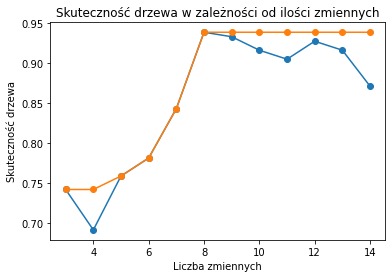

In [50]:
#viii
fig, ax = plt.subplots()
ax.set_xlabel("Liczba zmiennych")
ax.set_ylabel("Skuteczność drzewa")
ax.set_title("Skuteczność drzewa w zależności od ilości zmiennych")
ax.plot(list(range(3,15)),full_trees_scores, label="Drzewo pełne",marker='o')
ax.plot(list(range(3,15)),opt_trees_scores, label="Drzewo optymalne",marker='o')
ax.plot(list(range(3,15)),diffrence, label="Drzewo optymalne",marker='o')
ax.legend();

Widzimy, że dla drzewa optymalnego skuteczność jest średnio lepsza niż dla drzewa pełnego, ponadto obserwujemy wysoką skuteczność drzewa optymalnego powyzej uwzględniania 8 zmiennych

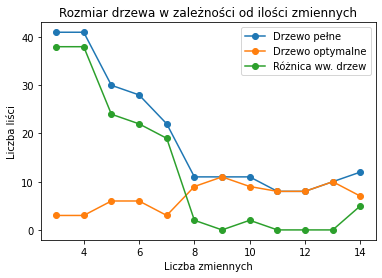

In [51]:
fig, ax = plt.subplots()
ax.set_xlabel("Liczba zmiennych")
ax.set_ylabel("Liczba liści")
ax.set_title("Rozmiar drzewa w zależności od ilości zmiennych")
ax.plot(list(range(3,15)),full_leaves, label="Drzewo pełne",marker='o')
ax.plot(list(range(3,15)),opt_leaves, label="Drzewo optymalne",marker='o')
ax.plot(list(range(3,15)),diffrence(full_leaves,opt_leaves), label="Różnica ww. drzew",marker='o')
ax.legend();

Dla większej liczby zmiennych obserwujemy podobieństwo w ilości liści pomiędzy drzewem pełnym a optymalnym.